Notebook to plot manuscript figures from paper

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy import integrate
import sympy as sp
import cmath 
from itertools import repeat
from copy import deepcopy
import matplotlib.ticker as ticker
from sympy import init_printing
init_printing()
from pathlib import Path
import re
import pickle
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import jax

In [16]:
from linlayermodel.LLMParams import LLMParams, Constants, RadiativeComputation, ConvectiveParams, LinearSolutions
from linlayermodel.PlotSTM import PlotSTM

In [17]:
# set cache directory
cache_dir = Path(f'../cache/')
cache_dir


PosixPath('../cache')

In [18]:
# set cache directory
nlayers = 4
theta0 = ['2.5', '10.0']
theta0_cache_dir = cache_dir /'parameter_perturbation' / f'theta0_n={nlayers}'
obj = {}
for theta in theta0:
    obj_path = theta0_cache_dir / f'theta0={theta}'
    obj_path = next( obj_path.glob('*.pkl') ) 
    obj[theta] = pickle.load(open(obj_path, 'rb'))

In [9]:
obj['2.5'].params_dict['conv'] 

In [14]:
def _get_params_radconv(obj:dict, k)->sp.Symbol:
    params = obj.params_dict
    args_r = obj.args_r
    epsilon = sp.IndexedBase(f'epsilon_{k}', **args_r)
    return epsilon

_get_params_radconv(obj['2.5'], 'sT')

In [5]:
obj['2.5'].Mcoeff_all

⎡                                                                        2     ↪
⎢                                                             - 1.0⋅D_T⋅k ⋅A[0 ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                               2              ↪
⎢                                            0.115372523016366⋅k ⋅M^\dagger_s[ ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                        2                  0. ↪
⎢                                     0.115372523016366⋅k ⋅M^\dagger_s[2] + ── ↪
⎢                                                                              ↪
⎢                           

In [19]:
# set plot directory
plot_dir = Path('../plots/Manuscript_Figures')
plot_dir.mkdir(exist_ok=True)

### Figure 2: Convection and radiation matrices


/home/fiaz/linear_layered_model/src/linlayermodel/PlotSTM.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/linear_layered_model/src/linlayermodel/PlotSTM.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/linear_layered_model/src/linlayermodel/PlotSTM.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(obj.pinterface)
/home/fiaz/linear_layered_model/src/linlayermodel/PlotSTM.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(1, obj.nlayers + 1, 1))
/home/fiaz/linear_layered_model/src/linlayermodel/PlotSTM.

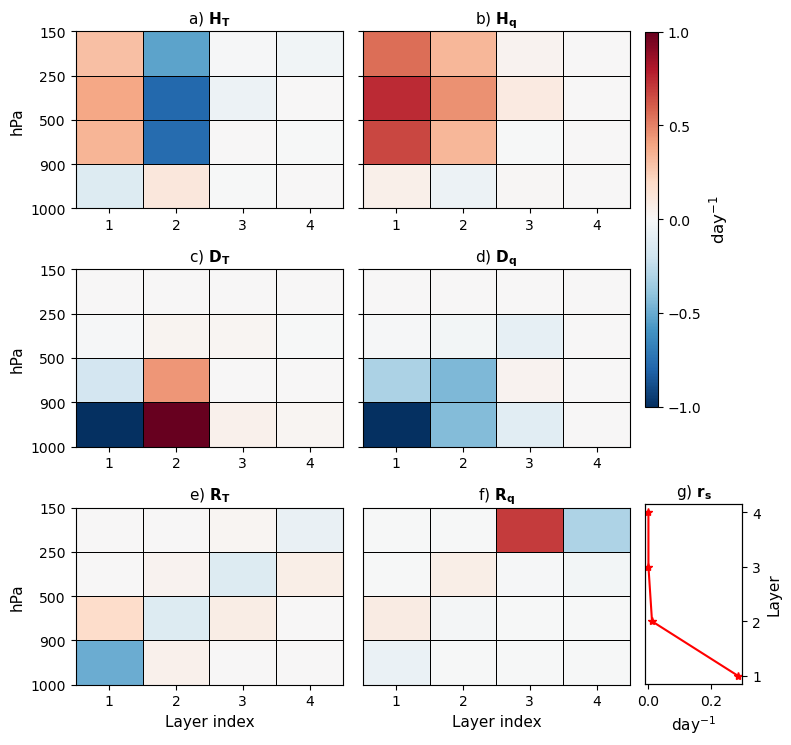

In [6]:
theta = '2.5'
plot_obj = PlotSTM(obj[theta], nlayers)
save_path = str(plot_dir) + '/'
plot_obj.plot_rad_conv_kernel(save_path, SAVE = False)

### Figure 3: Free modes

/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fiaz/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


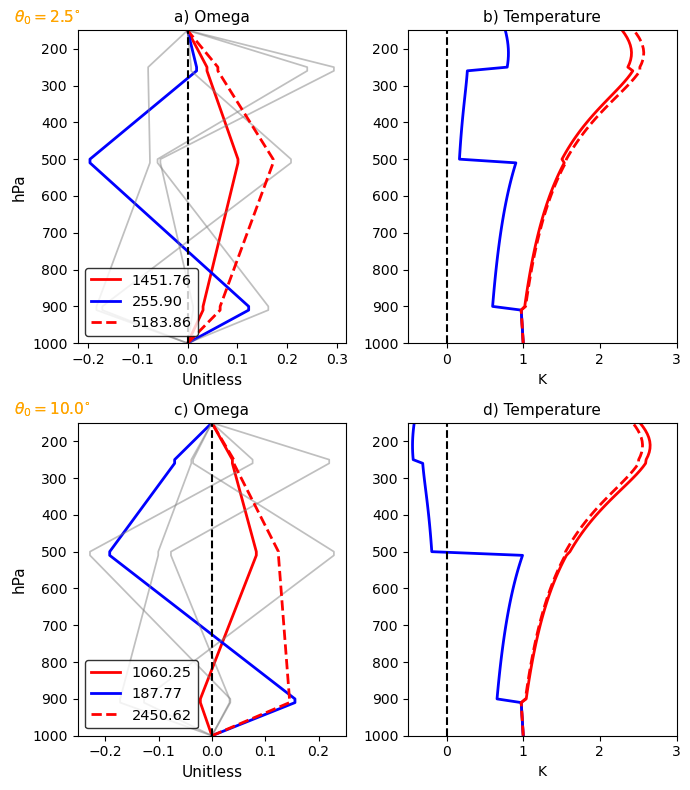

In [7]:
def plot_omega_structs(obj, k, ax, scaling_factor, start_panel = 'a'):
    """
    Wrapper to plot omega structures
    """
    nlayers = obj[k].nlayers
    plot_obj = PlotSTM(obj[k], nlayers)
    save_path = '/home/fiaz/STM/analysis/plots/Test/'
    plot_kwargs = dict(save_path = save_path, omega_scaling_factors =  scaling_factor, 
                    save_append = k, SAVE = False, start_panel = start_panel, ax = ax)
    plot_obj.plot_free_modes(**plot_kwargs)

fig, axx = plt.subplots(2, 2, figsize = (7., 8.))

theta = '2.5'
scaling_factor = np.array([1., 1.])
plot_omega_structs(obj, theta, axx[0], scaling_factor, 'a')
fstr = f'$\\theta_0 = {theta.split("_")[0]}^{{\\circ}}$ '

axx[0,0].annotate(fstr,
            xy=(2e-2, 0.96), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')
axx[0,0].annotate(fstr,
            xy=(2e-2, 0.96), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')


theta = '10.0'
scaling_factor = np.array([10., 1.])
plot_omega_structs(obj, theta, axx[1], scaling_factor, 'c')
fstr = f'$\\theta_0 = {theta.split("_")[0]}^{{\\circ}}$ '

axx[1,0].annotate(fstr,
            xy=(2e-2, 0.47), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')
axx[1,0].annotate(fstr,
            xy=(2e-2, 0.47), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')

SAVE = False
if SAVE:
    plt.savefig(str(plot_dir / 'free_modes.pdf'), dpi = 150, 
                bbox_inches = 'tight', format = 'pdf')




### Figure 4: Parameter perturbation experiments

In [20]:
def gen_files(pert_var:str, nlayers:int, pert_dir_path:Path)->dict[float, str]:

    def get_key(x, str):
        names = x.name.split('_')
        return '_'.join(names[1:])

    str_split = f'{pert_var}_n={nlayers}'
    fils_param_pert = pert_dir_path / f'{str_split}'
    fils = {get_key(f,pert_var+'=') : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}
    return fils

# fils_sbar_ft = gen_files('ft_sbar_pert', 4, cache_dir / 'parameter_perturbation')
# fils_sbar_bl = gen_files('bl_sbar_pert', 4, cache_dir / 'parameter_perturbation')

fils_sbar = gen_files('sbar_pert', 4, cache_dir / 'parameter_perturbation')
fils_qbar = gen_files('qbar_pert', 4, cache_dir / 'parameter_perturbation')
fils_sbar


{'pert=3.0_indx=3': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=3.0_indx=3/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=0.0_indx=1': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=0.0_indx=1/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=-1.0_indx=2': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=-1.0_indx=2/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=2.0_indx=0': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=2.0_indx=0/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=1.0_indx=2': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=1.0_indx=2/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=-0.5_indx=0': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=-0.5_indx=0/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=0.5_indx=0': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=0.5_indx=0/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pert=3.5_indx=2': '../cache/parameter_perturbation/sbar_pert_n=4/sbar_pert=3.5_indx=2/obj_n=4_x0=250km_theta=2.5deg.pkl',
 'pe

In [34]:
def get_L1_L2(fils:str, nlayers:int = 4):

    def _L1_L2_dict(fils:str):

        L1 = {}
        L2 = {}
        obj_temp = {}
        
        for k,v in fils.items():
            i,j = k.split('_')[0].split('pert=')[1], k.split('indx=')[1]
            obj_temp[k] = pickle.load(open(v, 'rb'))
            decay_scales = np.unique( sorted(list( obj_temp[k].decay_scales['conv'].values() ) )) 
            L1[(i,j)] = decay_scales[-1]
            L2[(i,j)] = decay_scales[-2]

            Msd = obj_temp[k].symbols['Msd']
            Msd0 = Msd[0]
            Msd1 = Msd[1]
            L1[(i,j)] = obj_temp[k].params_dict['general'][Msd0]
            L2[(i,j)] = obj_temp[k].params_dict['general'][Msd1]

        return L1, L2, obj_temp

    L1, L2, _ = _L1_L2_dict(fils)
    pert_array = np.unique([float(k) for k,_ in L1.keys()])

    def convert_dict_to_array(L:dict, pert_array:np.array)->np.array:
        L_new = np.zeros((len(pert_array), nlayers))
        for k1, k2 in L.keys():
            i = np.where(pert_array == float(k1))[0].item() 
            j = int(k2)
            L_new[i,j] = L[(k1,k2)]
        return L_new

    L1_new = convert_dict_to_array(L1, pert_array)
    L2_new = convert_dict_to_array(L2, pert_array)

    return L1_new - L1[('0.0','0')], L2_new - L2[('0.0','0')], pert_array


L1_qbar, L2_qbar, pert_array = get_L1_L2(fils_qbar)
L1_sbar, L2_sbar, _ = get_L1_L2(fils_sbar)

In [22]:
# pert_array = np.unique([float(k) for k,_ in L1.keys()])

# def convert_dict_to_array(L:dict, pert_array:np.array)->np.array:
#     L_new = np.zeros((len(pert_array), nlayers))
#     for k1, k2 in L.keys():
#         i = np.where(pert_array == float(k1))[0].item() 
#         j = int(k2)
#         L_new[i,j] = L[(k1,k2)]
#     return L_new
    
# L1_new = convert_dict_to_array(L1, pert_array)
# L2_new = convert_dict_to_array(L2, pert_array)

In [37]:
L1_sbar.min()

/tmp/ipykernel_2905562/844941688.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/844941688.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/844941688.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/844941688.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))


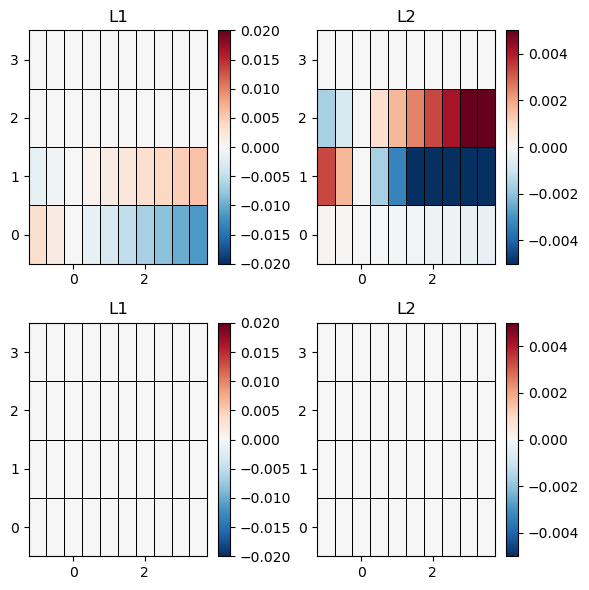

In [43]:
def plot_L1L2_matrix(axx, L1, L2)->None:

    ax = axx[0]
    ax.set_title('L1', fontsize = 12)
    p = ax.pcolormesh(pert_array, np.arange(nlayers), L1.T, 
                cmap = 'RdBu_r', vmin = -200e-4, vmax = 200e-4, 
                edgecolors = 'black', linewidths = 0.5)
    ax.set_yticklabels(np.arange(nlayers))
    ax.set_yticks(np.arange(nlayers))
    plt.colorbar(p, ax = ax)

    ax = axx[1]
    ax.set_title('L2', fontsize = 12)
    p = ax.pcolormesh(pert_array, np.arange(nlayers), L2.T, 
                cmap = 'RdBu_r', vmin = -50e-4, vmax = 50e-4, 
                edgecolors = 'black', linewidths = 0.5)
    ax.set_yticklabels(np.arange(nlayers))
    ax.set_yticks(np.arange(nlayers))
    plt.colorbar(p, ax = ax)


fig, axx = plt.subplots(2, 2, figsize = (6., 6.))


plot_L1L2_matrix(axx[0, :], L1_sbar, L2_sbar)
plot_L1L2_matrix(axx[1, :], L1_qbar, L2_qbar)

plt.tight_layout()


/tmp/ipykernel_2905562/3798849824.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/3798849824.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/3798849824.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))
/tmp/ipykernel_2905562/3798849824.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(nlayers))


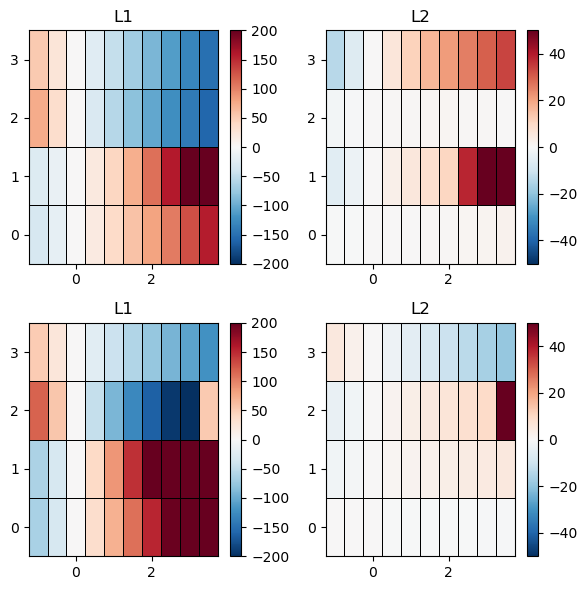

In [24]:
def plot_L1L2_matrix(axx, L1, L2)->None:

    ax = axx[0]
    ax.set_title('L1', fontsize = 12)
    p = ax.pcolormesh(pert_array, np.arange(nlayers), L1.T, 
                cmap = 'RdBu_r', vmin = -200, vmax = 200, 
                edgecolors = 'black', linewidths = 0.5)
    ax.set_yticklabels(np.arange(nlayers))
    ax.set_yticks(np.arange(nlayers))
    plt.colorbar(p, ax = ax)

    ax = axx[1]
    ax.set_title('L2', fontsize = 12)
    p = ax.pcolormesh(pert_array, np.arange(nlayers), L2.T, 
                cmap = 'RdBu_r', vmin = -50, vmax = 50, 
                edgecolors = 'black', linewidths = 0.5)
    ax.set_yticklabels(np.arange(nlayers))
    ax.set_yticks(np.arange(nlayers))
    plt.colorbar(p, ax = ax)


fig, axx = plt.subplots(2, 2, figsize = (6., 6.))


plot_L1L2_matrix(axx[0, :], L1_sbar, L2_sbar)
plot_L1L2_matrix(axx[1, :], L1_qbar, L2_qbar)

plt.tight_layout()


In [53]:
obj['2.5'].params_dict['conv']


In [28]:
(L2_new - L2_ctrl).max()

In [9]:
# @jax.jit
def get_L1_L2(fils, pert_symb):
    L1 = {}
    L2 = {}
    pert_val = {}
    obj_temp = {}
    for k,v in fils.items():
        obj_temp[k] = pickle.load(open(v, 'rb'))
        decay_scales = np.unique( sorted(list( obj_temp[k].decay_scales['conv'].values() ) )) 
        L1[k] = decay_scales[-1]
        L2[k] = decay_scales[-2]
        pert_val[k] = obj_temp[k].params_dict['general'][pert_symb]

    return L1, L2, pert_val, obj_temp
    # return decay_scales




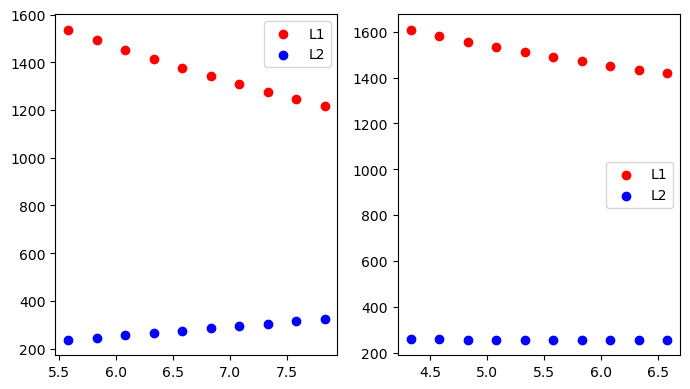

In [11]:
def get_sbar(obj, indx):
    return [obj_temp[k].phys_params['sbar_pert'][indx] for k in obj.keys()]

def get_sbar(obj, indx):
    return [ dse_bl( obj_temp[k] ) for k in obj.keys()]

def dse_bl(obj_temp):
     
    deltap = -np.diff(obj_temp.pinterface)
    Msref = [v for v in obj_temp.vert_struct_params['Msref'].values()]
    Msddref = obj_temp.dse_params['Msi_ddagger_ref']
    Msdref = obj_temp.dse_params['Msi_dagger_ref']

    sbar_bl =( Msref[0] + Msref[1] ) * 0.5
    MsF = (Msref[1:]  @ deltap[1:])/deltap[1:].sum()
    return sbar_bl - Msref[0]

# def get_sdeep(k, obj):
     
#     deltap = -np.diff(obj0.pinterface)
#     obj_temp = obj[k]
#     Msref = [v for v in obj_temp.vert_struct_params['Msref'].values()]
#     Msddref = obj_temp.dse_params['Msi_ddagger_ref']
#     Msdref = obj_temp.dse_params['Msi_dagger_ref']

#     sbar_bl =( Msref[0] + Msref[1] ) * 0.5
#     MsF = (Msref[1:]  @ deltap[1:])/deltap[1:].sum()
#     return  (Msdref[1] + Msdref[2] ) * Msref[0]


fig, axx = plt.subplots(1, 2, figsize = (7., 4.))

ax = axx[0]
L1, L2, pert_val, obj_temp = get_L1_L2(fils_sbar_ft, obj['2.5'].symbols['kappa_s'])
get_sbar(obj_temp, 1)
ax.scatter(get_sbar(obj_temp, 1), list(L1.values()), label = 'L1', c = 'red')
ax.scatter(get_sbar(obj_temp, 1), list(L2.values()), label = 'L2', c = 'blue')
ax.legend()

ax = axx[1]
L1, L2, pert_val, obj_temp = get_L1_L2(fils_sbar_bl, obj['2.5'].symbols['kappa_s'])
get_sbar(obj_temp, 1)
ax.scatter(get_sbar(obj_temp, 0), list(L1.values()), label = 'L1', c = 'red')
ax.scatter(get_sbar(obj_temp, 0), list(L2.values()), label = 'L2', c = 'blue')
ax.legend()

plt.tight_layout()


In [143]:
len( get_sbar(obj_temp, 1) ), len(obj_temp)

In [126]:
obj_temp

{2.0: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1c1715b0>,
 3.0: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b98a0f0>,
 -0.5: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b144350>,
 1.0: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1c4fde50>,
 0.0: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b4a3b00>,
 1.5: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b4a3da0>,
 0.5: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1c173ef0>,
 -1.0: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b1585c0>,
 2.5: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b436d50>,
 3.5: <linlayermodel.LLMParams.LinearSolutions at 0x7f3a1b0e7830>}

In [125]:
obj_temp[0].phys_params['sbar_pert'][0]

Forced Modes

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


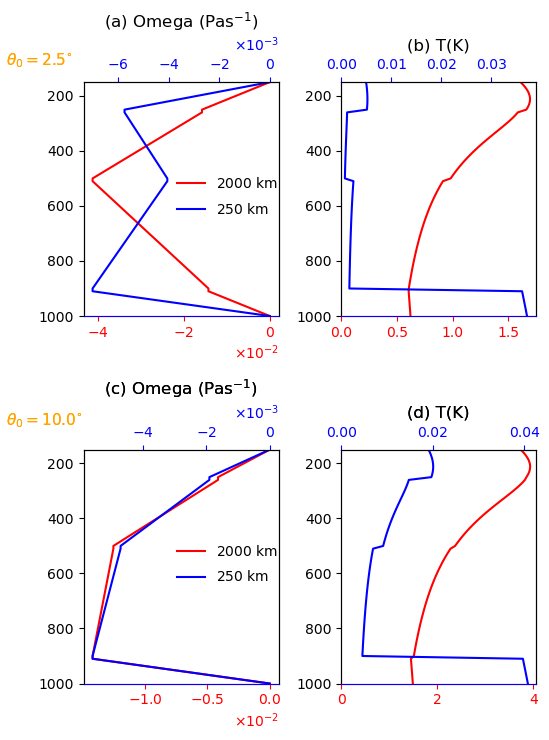

In [17]:
def plot_forced_structs(obj, k, axx, color, titles):
    
    """
    Wrapper to plot forced solutions
    """
    nlayers = obj[k].nlayers
    plot_obj = PlotSTM(obj[k], nlayers)
    fstr = f'${k.split("_")[1]}$ km'
    plot_params = dict(ax = axx, color = color, leg_label = fstr, SAVE = False)
    for i,ax in enumerate(axx):
        ax.spines['bottom'].set_color(color)
        ax.tick_params(axis='x', colors = color)
        ax.set_title(titles[i])

    plot_obj.plot_forced_mode_profiles(None, **plot_params)

fig, axx = plt.subplots(2, 2, figsize=(5.5, 7.5))

k = '2.5_2000'
titles = ['(a) Omega ($\mathrm{Pas^{-1}}$)', '(b) T(K)', '(c) q(K)', 'd']

plot_forced_structs(obj, k, axx[0], 'red', titles )

k = '2.5_250'
titles = [''] * 3

axx2 = [ax.twiny() for ax in axx[0]]
plot_forced_structs(obj, k, axx2, 'blue', titles )

fstr = f'$\\theta_0 = {k.split("_")[0]}^{{\circ}}$ '

axx[0,0].annotate(fstr,
            xy=(1e-2, 0.9), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')

axx[0,0].annotate(fstr,
            xy=(1e-2, 0.9), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')

handles1, labels1 = axx[0, 0].get_legend_handles_labels()
handles2, labels2 = axx2[0].get_legend_handles_labels()

leg1 = axx[0, 0].legend( loc = (0.45, 0.51), ncol = 1, fontsize = 10, frameon = False)
leg2 = axx2[0].legend( loc = (0.45, 0.4), ncol = 1, fontsize = 10, frameon = False)


k = '10.0_2000'
titles = ['(c) Omega ($\mathrm{Pas^{-1}}$)', '(d) T(K)']

plot_forced_structs(obj, k, axx[1], 'red', titles )

k = '10.0_250'
axx2 = [ax.twiny() for ax in axx[1]]
plot_forced_structs(obj, k, axx2, 'blue', titles )

fstr = f'$\\theta_0 = {k.split("_")[0]}^{{\circ}}$ '

axx[1,0].annotate(fstr,
            xy=(1e-2, 0.42), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')

axx[1,0].annotate(fstr,
            xy=(1e-2, 0.42), xycoords='figure fraction',
            fontsize=11, fontweight='bold', color = 'orange')

handles1, labels1 = axx[1, 0].get_legend_handles_labels()
handles2, labels2 = axx2[0].get_legend_handles_labels()

leg1 = axx[1, 0].legend( loc = (0.45, 0.51), ncol = 1, fontsize = 10, frameon = False)
leg2 = axx2[0].legend( loc = (0.45, 0.4), ncol = 1, fontsize = 10, frameon = False)

SAVE = True
if SAVE:
    save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
    plt.savefig(save_path + 'forced_solutions.pdf', dpi = 150, 
                bbox_inches = 'tight', format = 'pdf')



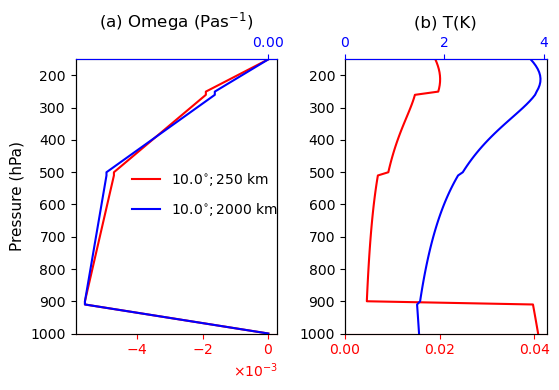

In [ ]:
fig, axx = plt.subplots(1, 2, figsize=(5.5, 4))
axx2 = [ax.twiny() for ax in axx]

k = '2.5_2000'
# k = '2.5_250'
k = '10.0_250'

nlayers = obj[k].nlayers
plot_obj = PlotSTM(obj[k], nlayers)
fstr = f'${k.split("_")[0]}^{{\circ}}; {k.split("_")[1]}$ km'

plot_params = dict(ax = axx, color = 'red', leg_label = fstr,SAVE = False)
titles = ['(a) Omega ($\mathrm{Pas^{-1}}$)', '(b) T(K)', '(c) q(K)', 'd']
for i,ax in enumerate(axx):
    ax.spines['bottom'].set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.set_title(titles[i])

plot_obj.plot_forced_mode_profiles(None, **plot_params)

# k = '10.0_250'
k = '10.0_2000'

nlayers = obj[k].nlayers
plot_obj = PlotSTM(obj[k], nlayers)
fstr = f'${k.split("_")[0]}^{{\circ}}; {k.split("_")[1]}$ km'
plot_params = dict(ax = axx2, color = 'blue', leg_label = fstr, SAVE = False)
plot_obj.plot_forced_mode_profiles(None, **plot_params)

for ax in axx2:
    ax.spines['top'].set_color('blue')
    ax.tick_params(axis='x', colors='blue')

handles1, labels1 = axx[0].get_legend_handles_labels()
handles2, labels2 = axx2[0].get_legend_handles_labels()

leg1 = axx[0].legend( loc = (0.25, 0.51), ncol = 1, fontsize = 10, frameon = False)
leg2 = axx2[0].legend( loc = (0.25, 0.4), ncol = 1, fontsize = 10, frameon = False)

axx[0].set_ylabel('Pressure (hPa)', fontsize = 11)

# [leg.get_frame().set_edgecolor('white') for leg in [leg1, leg2]]
# all_handles = handles1 + handles2
# all_labels = labels1 + labels2

# leg = axx[0].legend(all_handles, all_labels, loc = (0.35, 0.45), ncol = 1, fontsize = 10)
# leg.get_frame().set_edgecolor('black')

SAVE = False
if SAVE:
    save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
    plt.savefig(save_path + 'forced_solutions.pdf', dpi = 150, 
                bbox_inches = 'tight', format = 'pdf')

In [165]:
fstr = f'{k.split("_")[0]}^{{\circ}}; {k.split("_")[1]}$ km'
fstr

'10.0^{\\circ}; 250$ km'

In [118]:
k = '10.0_2000'
obj[k].decay_scales_trunc

{'conv': {12: -1060.1851705399802,
  13: -1060.1851705399802,
  14: 1060.1851705399793,
  15: 1060.1851705399793,
  10: -187.76279225247632,
  11: 187.76279225247612,
  5: -101.31892814204014,
  9: 101.31892814203982,
  7: 85.07935474380977,
  8: 85.07935474380977,
  3: -85.07935474380973,
  4: -85.07935474380973,
  6: 73.34205144155199,
  2: -73.34205144155179,
  0: -60.017753749090716,
  1: 60.01775374909062},
 'nconv': {7: -2450.042796075704,
  6: -876.7671647476318,
  5: -200.39669748160125,
  4: -107.28703195781236,
  2: -85.27227438563187,
  3: -85.27227438563187,
  1: -78.83128286888558,
  0: -60.0337798604702}}

(-0.14165531823687608-0.1928782861665052j) (0.031454447382827364+1.0505673029558316e-17j)
(0.016561664249139157+0.007033993104081074j) (0.0022588304841899285-8.19200221862417e-18j)
(0.01745209624579259+0.036263254006318045j) (-0.009940917646982596+2.087999884787487e-17j)
(0.02101426485164358+0.05912607482877516j) (-0.013260239180127085-2.74883626223399e-17j)


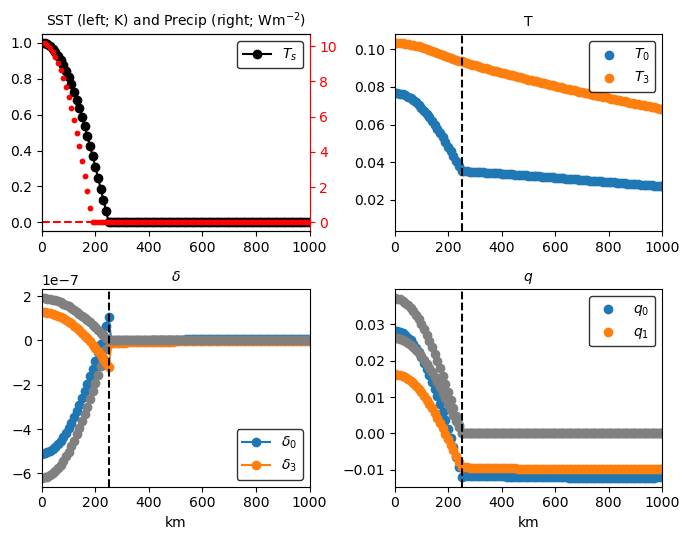

In [32]:
k = '10.0_250'
plot_obj = PlotSTM(obj[k], nlayers)
save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
plot_obj.plot_matching(save_path, k, SAVE = False)

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


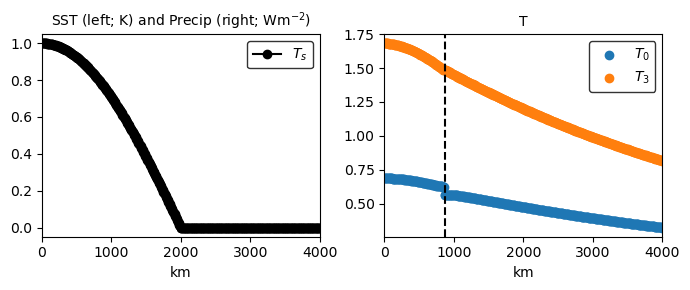

In [9]:
k = '2.5_2000'
plot_obj = PlotSTM(obj[k], nlayers)
save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
plot_obj.plot_matching_sst_temp(save_path, k+'sst_only', SAVE = False)


In [134]:
obj.keys()

dict_keys(['10.0_300', '2.5_300', '10.0_250', '10.0_2000', '2.5_2000'])

/home/fiaz/STM/analysis/PlotSTM.py:539: ComplexWarning: Casting complex values to real discards the imaginary part
  omega_full[xi, :], _ = obj.compute_omega_profile(div_temp)
/home/fiaz/STM/analysis/PlotSTM.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  omega_forced[xi, :], _ = obj.compute_omega_profile(div_temp)


[-1.  0.]


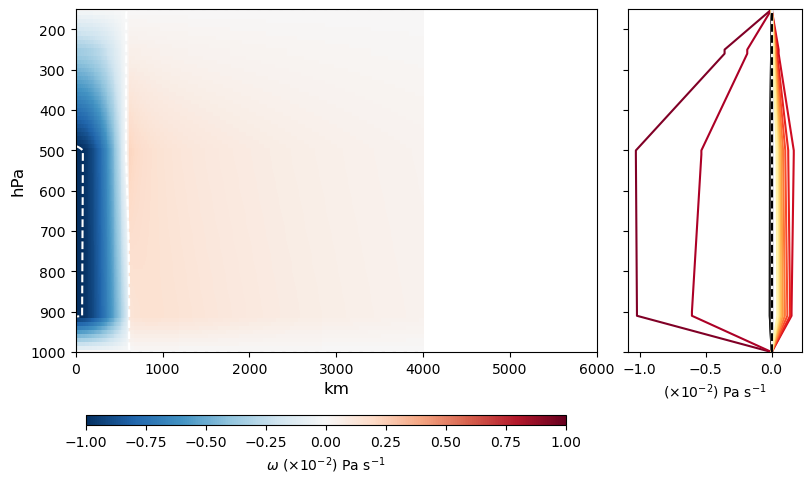

In [143]:
k = '10.0_250'
k = '10.0_2000'

# k = '2.5_250'
# k = '2.5_2000'


plot_obj = PlotSTM(obj[k], nlayers)

save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
plot_obj.plot_omega(save_path, k, SAVE = False)

### Parameter perturbation experiments

In [3]:
get_key = lambda x, str: float( x.name.split(str)[-1] )

str_split = 'n=4_epsilon_f='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/epsilon_f_x0=250.0')
fils_epsilonb = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_epsilon_fi='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/epsilon_fi_x0=250.0')
fils_epsilonf = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}


str_split = 'n=4_kappas_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/kappas_pert_x0=250.0')
fils_kappa = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_fp='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/fp_x0=250.0')

fils_fp = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_theta0='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/theta0_x0=250.0')
fils_theta0 = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_sbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/sbar_pert_x0=250.0')
fils_sbar = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_sbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/sbar_pert_x0=250.0_sbar2_pert')
fils_sbar2 = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_sbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/sbar_pert_x0=250.0_sbar_pert_upper')
fils_sbar3 = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_sbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/sbar_pert_x0=250.0_sbar_pert_all')
fils_sbar4 = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_qbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/qbar_pert_x0=250.0')
fils_qbar = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

str_split = 'n=4_qbar_pert='
fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/qbar_pert_x0=250.0_qbar2_pert')
fils_qbar2 = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# str_split = 'n=4_thermo_pert='
# # fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_reponse_bl_pert')
# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_lft_pert')

# fils_thermo = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_bl_pert')
# fils_thermo_bl_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_bl_heating_bl_pert')
# fils_thermo_bl_heating_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ftbl_heating_ftbl_pert')
# fils_thermo_ftbl_heating_ftbl_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_ftq_pert')
# fils_thermo_ft_heating_ftq_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_blq_pert')
# fils_thermo_ft_heating_blq_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_drying_qT_pert')
# fils_thermo_ft_drying_qT_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}

# fils_param_pert = Path('/home/fiaz/STM/analysis/parameter_perturbation/thermo_pert_x0=250.0_ft_heating_qT_ftbl_pert')
# fils_thermo_ft_heating_qT_ftbl_pert = {get_key(f,str_split) : str([i for i in f.glob('*pkl')][0]) for f in fils_param_pert.glob('*')}



In [ ]:
def get_L1_L2(fils, pert_symb):
    L1 = {}
    L2 = {}
    pert_val = {}
    obj_temp = {}
    for k,v in fils.items():
        obj_temp[k] = pickle.load(open(v, 'rb'))
        decay_scales = obj_temp[k].decay_scales_trunc['conv']   
        L1[k] = decay_scales[list( decay_scales.keys() )[0]]
        L2[k] = decay_scales[list( decay_scales.keys() )[4]]
        pert_val[k] = obj_temp[k].params_dict['general'][pert_symb]

    return L1, L2, pert_val, obj_temp

In [5]:
obj0 = obj['10.0_300']
L1_kappa, L2_kappa, kappa_vals, obj_kappa = get_L1_L2(fils_kappa, obj0.symbols['kappa_s'])

In [6]:
tauf = obj0.symbols['tau_f']
obj0.params_dict['general'][tauf[0]]

In [7]:
L1_epsilonb, L2_epsilonb, _, obj_epsb = get_L1_L2(fils_epsilonb, obj0.symbols['kappa_s'])

In [8]:
L1_epsilonf, L2_epsilonf, _, obj_epsf = get_L1_L2(fils_epsilonf, obj0.symbols['kappa_s'])

In [9]:
L1_theta0, L2_theta0, _, obj_theta0 = get_L1_L2(fils_theta0, obj0.symbols['kappa_s'])

In [10]:
L1_fp, L2_fp, _, obj_fp = get_L1_L2(fils_fp, obj0.symbols['kappa_s'])

In [16]:
# L1_thermo, L2_thermo, _ = get_L1_L2(fils_thermo_ft_heating_qT_ftbl_pert, obj['10.0_300'].symbols['kappa_s'])

In [11]:
L1_sbar, L2_sbar, _, obj_sbar = get_L1_L2(fils_sbar, obj0.symbols['kappa_s'])
# L1_qbar, L2_qbar, _, _ = get_L1_L2(fils_qbar, obj0.symbols['kappa_s'])

In [ ]:
k = [0.025]
[ L1_fp.pop(i) for i in k ]
[ L2_fp.pop(i) for i in k ]

# k = [4.0]
# [i.pop(j, None) for i in [L1_qbar, L2_qbar] for j in k]
# [i.pop(j, None) for i in [L1_sbar, L2_sbar] for j in k]


In [151]:
obj0 = obj['10.0_300']
taub = obj0.mom_params['tau_i'][0]

def get_kappa_vals(k, obj):
    obj_temp = obj[k]
    taub = obj_temp.mom_params['tau_i'][0]
    return obj_temp.params_dict['general'][obj_temp.symbols['kappa_s']] * 86400/taub

# get_kappa_vals = lambda k: obj0.params_dict['general'][obj0.symbols['kappa_s']] * 86400/taub + k
percent_change = lambda x,x0: (x-x0)/x0 * 100

def get_taub_vals(k, obj):
    obj_temp = obj[k]
    epsilonb = obj0.phys_params['epsilon_f'][0] + k/86400
    f = obj0.phys_params['f']
    tau_b = epsilonb / ( pow(f,2)  + pow(epsilonb,2) )
    tau = obj_temp.mom_params['tau_i'][0]

    return tau/86400

def get_tauf_vals(k, obj):
    obj_temp = obj[k]
    epsilonf = obj0.phys_params['epsilon_f'][1] + k/86400
    f = obj0.phys_params['f']
    tau = epsilonf / ( pow(f,2)  + pow(epsilonf,2) )
    tau = obj_temp.mom_params['tau_i'][1]

    return tau/86400

def get_tau_from_theta(k, obj):
    """
    For a given theta perturbation, calculate the corresponding tau
    """
    obj_temp = obj[k]
    tau_i = obj_temp.mom_params['tau_i']
    tau_if = obj_temp.mom_params['tau_if']

    return tau_if[0] #/ tau_if[0] #/ 86400
    # return tau_if[0] * tau_f[1]
    return k

def get_sbl(k, obj):
     
    deltap = -np.diff(obj0.pinterface)
    obj_temp = obj[k]
    Msref = [v for v in obj_temp.vert_struct_params['Msref'].values()]
    Msddref = obj_temp.dse_params['Msi_ddagger_ref']
    Msdref = obj_temp.dse_params['Msi_dagger_ref']

    sbar_bl =( Msref[0] + Msref[1] ) * 0.5
    MsF = (Msref[1:]  @ deltap[1:])/deltap[1:].sum()
    return sbar_bl - Msref[0]

def get_sdeep(k, obj):
     
    deltap = -np.diff(obj0.pinterface)
    obj_temp = obj[k]
    Msref = [v for v in obj_temp.vert_struct_params['Msref'].values()]
    Msddref = obj_temp.dse_params['Msi_ddagger_ref']
    Msdref = obj_temp.dse_params['Msi_dagger_ref']

    sbar_bl =( Msref[0] + Msref[1] ) * 0.5
    MsF = (Msref[1:]  @ deltap[1:])/deltap[1:].sum()
    return  (Msdref[1] + Msdref[2] ) * Msref[0]

def plot_L1L2(L1, L2,  xaxis_func, xaxis2_func, ctrl_key, ax, args, **plot_params):
    

    xlabel = plot_params['xlabel']
    ylabel1 = plot_params['ylabel1']
    ylabel2 = plot_params['ylabel2']
    
    if xaxis2_func:
        ax2 = ax.twinx().twiny()
        x2 = []
    else:
        ax2 = ax.twinx() 


    for n, (k,v) in enumerate(L1.items()):

        x = xaxis_func(k, *args)
        if xaxis2_func:
            x2 = xaxis2_func(k, *args) 

        if k == ctrl_key:
            s = 80
            marker = '*'
            x0 = x
        else:
            s = 30
            marker = 'o'

        y1, y2 = abs(v), abs(L2[k])
        ax.scatter(x, percent_change( y1, abs(L1[ctrl_key]) ), c = 'red', marker = marker, s = s)
        
        if xaxis2_func:
            ax2.scatter(x2, percent_change( y2, abs(L2[ctrl_key]) ), c = 'blue', alpha = 0.5, marker = marker, s = s)
        else:
            ax2.scatter(x, percent_change( y2, abs(L2[ctrl_key]) ), c = 'blue', alpha = 0.5, marker = marker, s = s)

    ax.spines['left'].set_color('red')
    ax.tick_params(axis='y', colors='red')
    ax2.tick_params(axis='y', colors='blue')
    
    ax2.spines['left'].set_color('red')
    ax2.spines['right'].set_color('blue')

    ax.set_ylabel(ylabel1, fontsize = 11, color = 'red')
    ax2.set_ylabel(ylabel2, fontsize = 11, color = 'blue')
    ax.set_xlabel(xlabel, fontsize = 11)
    ax2.tick_params(axis='y', colors='blue')

    if xaxis2_func:

        ax2.spines['top'].set_color('blue')
        ax2.tick_params(axis = 'x', colors = 'blue')
        ax.tick_params(axis = 'x', colors = 'red')
        # ax21.tick_params(axis = 'y', colors = 'blue')
        ax2.spines['bottom'].set_color('red')
        ax.set_xlabel('', fontsize = 11)

        xl1, xl2 = xlabel.split(',')
        xl1 += ','
        xbox1 = TextArea(xl1, textprops=dict(color="r", size=11,rotation=0, ha='left',va='bottom'))
        # xbox2 = TextArea(',', textprops=dict(color="k", size=11,rotation=0, ha='left',va='bottom'))
        xbox3 = TextArea(xl2, textprops=dict(color="b", size=11,rotation=0, ha='left',va='bottom'))
        xbox = HPacker(children=[xbox1, xbox3],align="bottom", pad=0, sep=5)

        anchored_ybox = AnchoredOffsetbox(loc=8, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.475, -0.25), 
                                        bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)




    yt,yb = ax.get_ylim()
    # ax.vlines(x0, yb, yt, color = 'black', 
    #           linestyle = '--', alpha = 0.5, zorder = -1)
    ax.set_ylim(yt, yb)
    ax.set_title(plot_params['title'], fontsize = 12)

/tmp/ipykernel_1963927/2268838043.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


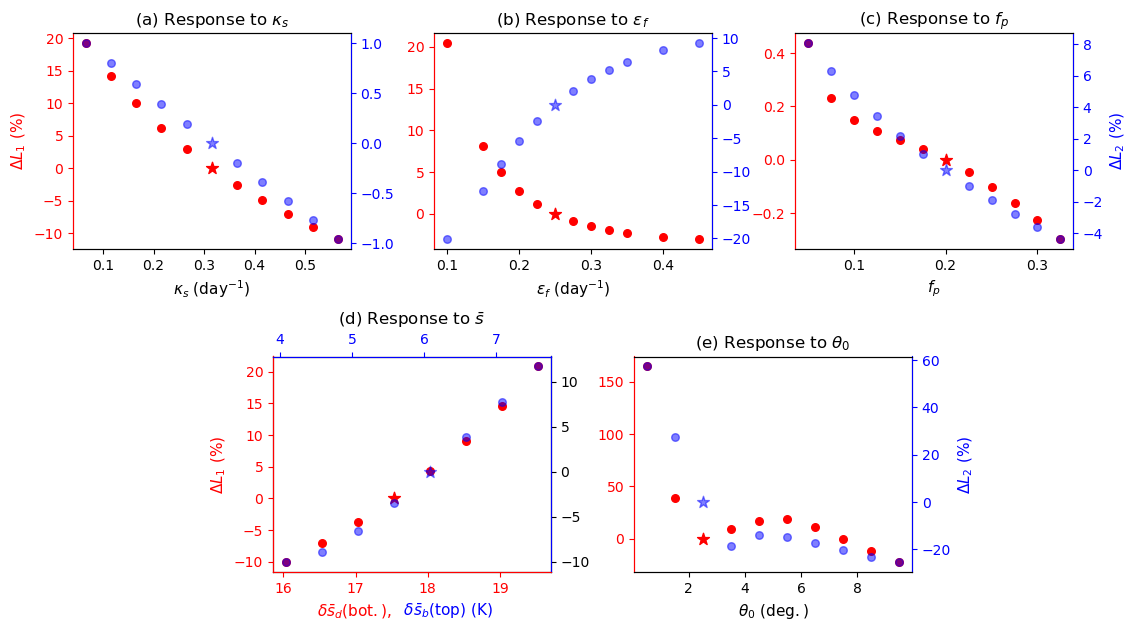

In [153]:
panel_label = (chr(i) for i in range(97, 123))

fig = plt.figure(figsize = (10, 7))

gs1 = GridSpec(2, 3, left = 0., right=1, wspace = 0.3, hspace = 0.5)
ax = fig.add_subplot(gs1[0, 0])
plot_params = dict(axes = ax, xlabel = r'$\kappa_s\ (\mathrm{day^{-1}}) $', 
                   ylabel1 = r'$\Delta L_1\ (\%)$',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\kappa_s$')
plot_L1L2(L1_kappa, L2_kappa, get_kappa_vals, None, 0.0, ax, [obj_kappa], **plot_params)


ax = fig.add_subplot(gs1[0, 1])

plot_params = dict(axes = ax, xlabel = r'$\epsilon_f\ (\mathrm{day^{-1}}) $', 
                   ylabel1 = '',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\epsilon_f$')
plot_L1L2(L1_epsilonf, L2_epsilonf, lambda k, _ : k, None, 0.25, ax, [obj_epsf], **plot_params)

ax = fig.add_subplot(gs1[0, 2])
plot_params = dict(axes = ax, xlabel = r'$f_p$', 
                    ylabel1 = '', ylabel2 = r'$\Delta L_2\ (\%)$',
                   title = f'({next(panel_label)}) Response to $f_p$')
plot_L1L2(L1_fp, L2_fp, lambda k, o : k, None, 0.2, ax, [None], **plot_params)


gs2 = GridSpec(2, 3, left = .2, right=1.2, wspace = 0.3, hspace = .5)

ax = fig.add_subplot(gs2[1, 0])
plot_params = dict(axes = ax, xlabel = r'$\delta\bar{s}_d(\mathrm{ bot.})$, $\delta\bar{s}_b\mathrm{ (top)}\ (\mathrm{K}) $', 
                   ylabel1 = r'$\Delta L_1\ (\%)$',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\\bar{{s}}$')
plot_L1L2(L1_sbar, L2_sbar, get_sdeep , get_sbl, 0.0, ax, [obj_sbar], **plot_params)



ax = fig.add_subplot(gs2[1, 1])

plot_params = dict(axes = ax, xlabel = r'$\theta_0\ (\mathrm{deg.}) $', 
                    ylabel1 = '',  ylabel2 = r'$\Delta L_2\ (\%)$',
                   title = f'({next(panel_label)}) Response to $\\theta_0$')
L1_theta0_sorted = dict(sorted(L1_theta0.items()))
L2_theta0_sorted = dict(sorted(L2_theta0.items()))

plot_L1L2(L1_theta0_sorted, L2_theta0_sorted, lambda k, _ : k, None, 
          2.5, ax, [obj_theta0], **plot_params)

plt.tight_layout()
SAVE = True
if SAVE:
    save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
    plt.savefig(save_path + 'L1L2_perturbations.pdf', dpi = 150, 
                bbox_inches = 'tight', format = 'pdf')




In [124]:
xlabel = r'$\delta\bar{s}_d(\mathrm{ bot.})$, $\delta\bar{s}_b\mathrm{ (top)}\ (\mathrm{K}) $'
xlabel.split(',')

['$\\delta\\bar{s}_d(\\mathrm{ bot.})$',
 ' $\\delta\\bar{s}_b\\mathrm{ (top)}\\ (\\mathrm{K}) $']

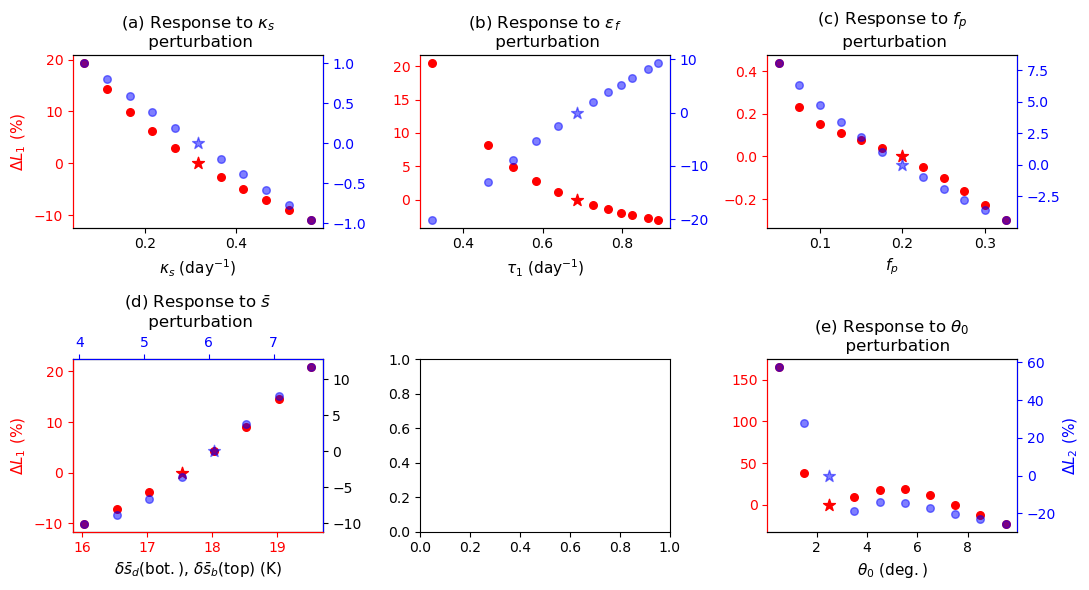

In [ ]:
fig, axx = plt.subplots(2, 3, figsize = (11, 6))

panel_label = (chr(i) for i in range(97, 123))


ax = axx[0, 0]
plot_params = dict(axes = ax, xlabel = r'$\kappa_s\ (\mathrm{day^{-1}}) $', 
                   ylabel1 = r'$\Delta L_1\ (\%)$',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\kappa_s$\n perturbation')
plot_L1L2(L1_kappa, L2_kappa, get_kappa_vals, None, 0.0, ax, [obj_kappa], **plot_params)

# ax = axx[0, 1]
# plot_params = dict(axes = ax, xlabel = r'$\tau_{0}\ (\mathrm{day^{-1}}) $', 
#                     ylabel1 = '',  ylabel2 = '',
#                    title = f'({next(panel_label)}) Response to $\epsilon_b$ \n perturbation')
# plot_L1L2(L1_epsilonb, L2_epsilonb, get_taub_vals, None, 2.5, ax, [obj_epsb], **plot_params)

ax = axx[0, 1]
plot_params = dict(axes = ax, xlabel = r'$\tau_{1}\ (\mathrm{day^{-1}}) $', 
                   ylabel1 = '',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\epsilon_f$\n perturbation')
plot_L1L2(L1_epsilonf, L2_epsilonf, get_tauf_vals, None, 0.25, ax, [obj_epsf], **plot_params)


ax = axx[0, 2]
plot_params = dict(axes = ax, xlabel = r'$f_p$', 
                    ylabel1 = '', ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $f_p$\n perturbation')
plot_L1L2(L1_fp, L2_fp, lambda k, o : k, None, 0.2, ax, [None], **plot_params)



ax = axx[1, 0]
plot_params = dict(axes = ax, xlabel = r'$\delta\bar{s}_d(\mathrm{ bot.})$, $\delta\bar{s}_b\mathrm{ (top)}\ (\mathrm{K}) $', 
                   ylabel1 = r'$\Delta L_1\ (\%)$',  ylabel2 = '',
                   title = f'({next(panel_label)}) Response to $\\bar{{s}}$ \n perturbation')
# plot_L1L2(L1_sbar4, L2_sbar4, get_Msref_sbar, 0.0, ax, **plot_params)
# plot_L1L2(L1_sbar, L2_sbar, get_sbl , 0.0, ax, [obj_sbar], **plot_params)
plot_L1L2(L1_sbar, L2_sbar, get_sdeep , get_sbl, 0.0, ax, [obj_sbar], **plot_params)





ax = axx[1, 2]
plot_params = dict(axes = ax, xlabel = r'$\theta_0\ (\mathrm{deg.}) $', 
                    ylabel1 = '',  ylabel2 = r'$\Delta L_2\ (\%)$',
                   title = f'({next(panel_label)}) Response to $\\theta_0$\n  perturbation')
# plot_L1L2(L1_theta0, L2_theta0, get_tau_from_theta, 2.5, ax, [obj_theta0],**plot_params)
# plot_L1L2(L1_theta0, L2_theta0, lambda k, _ : k, 2.5, ax, [obj_theta0], **plot_params)
L1_theta0_sorted = dict(sorted(L1_theta0.items()))
L2_theta0_sorted = dict(sorted(L2_theta0.items()))

# plot_L1L2_array(L1_theta0_sorted, L2_theta0_sorted, get_tau_from_theta, 2.5, ax, [obj_theta0],**plot_params)
plot_L1L2(L1_theta0_sorted, L2_theta0_sorted, lambda k, _ : k, None, 
          2.5, ax, [obj_theta0], **plot_params)

plt.tight_layout()
SAVE = False
if SAVE:
    save_path = '/home/fiaz/STM/analysis/plots/Storyboard/'
    plt.savefig(save_path + 'L1L2_perturbations.pdf', dpi = 150, 
                bbox_inches = 'tight', format = 'pdf')


## Supplementary figures

In [10]:
# obj.deltap 
k = '10.0_2000'

tau_i_func = lambda x,f: x/(pow(x,2) + pow(f  , 2)) * 1./86400  # in hours
epsf = obj[k].phys_params['epsilon_f'][1]
eps_range = np.arange(epsf * 0.5, epsf * 5, epsf * 0.25)
theta_range = np.arange(1., 15.5, .5)
frange =  2 * obj[k].phys_params['Omega'] * np.sin(np.deg2rad(theta_range))

tau_i = np.asarray( [ [tau_i_func(i, j) for i in eps_range] for j in frange])

def tau_if_func(obj, frange):

    tau_i = np.asarray([tau_i_func(obj.phys_params['epsilon_f'], f) for f in frange])
    tau_if = (tau_i * obj.deltap)/(tau_i @ obj.deltap)[:, None]
    assert np.allclose(tau_if.sum(1), 1)
    return tau_if



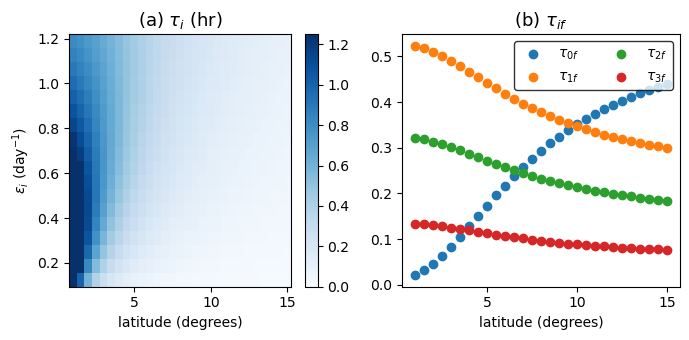

In [11]:
fig, axx = plt.subplots(1, 2, figsize=(7, 3.5))

ax = axx[1]
for i in range(obj[k].nlayers):
    ci = obj[k].mom_params['ci'][i]
    ax.scatter(theta_range,  tau_if_func(obj[k], frange)[:, i], label = f'$\\tau_{{ {i} f}}$')

ax.set_xlabel(r'latitude (degrees)')
# ax.set_ylabel(r'$\tau_{if}$', fontsize = 12)
ax.set_title(r'(b) $\tau_{if}$ ', fontsize = 13)

leg = ax.legend(ncol = 2)
leg.get_frame().set_edgecolor('k')


ax = axx[0]
cm = ax.pcolormesh(theta_range, (eps_range * 86400), tau_i.T, vmax = 1.25, vmin = 0, cmap = 'Blues')
ax.set_xlabel(r'latitude (degrees)')
ax.set_ylabel(r'$\epsilon_i\ ({\mathrm{day}}^{-1})$')
ax.set_title(r'(a) $\tau_i$ (hr)', fontsize = 13)
plt.colorbar(cm)
plt.tight_layout()

SAVE = False
if SAVE:
    plt.savefig('/home/fiaz/STM/analysis/plots/Storyboard/tau_if_variations.pdf', dpi = 120, 
                bbox_inches = 'tight', format = 'pdf')

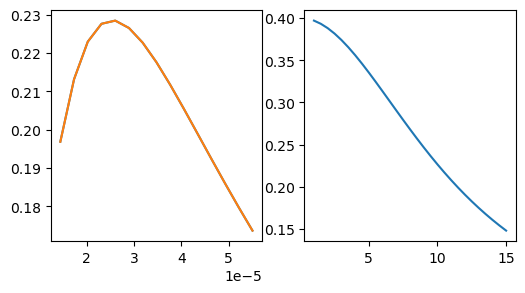

In [20]:
from itertools import repeat
fig, axx = plt.subplots(1, 2, figsize=(6, 3))
ax = axx[0]

epsb = obj[k].phys_params['epsilon_f'][0]
e = np.arange(epsb * 0.5, epsb * 2, epsb * 0.1)
f = obj[k].phys_params['f']
ax.plot(e, list( map(tau_i_func, e, repeat(f)) ) )
ax.plot(e, list( map(tau_i_func, e, repeat(f)) ) )


def get_bl_ft_coeffs(obj, epsb):

    taub = tau_i(epsb)
    obj[k].get_bl_ft_coeffs(epsb, epsf)
    return obj[k].bl_ft_coeffs


def get_f_coeffs(obj, theta):
    f = 2 * obj.phys_params['Omega'] * np.sin(np.deg2rad(theta))
    return tau_i_func(obj.phys_params['epsilon_f'][0], f)
    

ax = axx[1]
ax.plot(theta_range, list(map(get_f_coeffs, repeat(obj[k]), theta_range)) )


## Vertical structures

In [26]:
sbar = [v for k,v in obj[k].vert_struct_params['Msref'].items()]
qbar = [v for k,v in obj[k].vert_struct_params['Mqref'].items()]
# aprof = [v for k,v in obj[k].vert_struct_params['ap'].items()]

alist = ([v for k,v in obj[k].vert_struct_params['a_profiles'].items()])
alist = [b for a in alist for b in a]

blist = ([v for k,v in obj[k].vert_struct_params['b_profiles'].items()])
blist = [b for a in blist for b in a]

aplist = ([v for k,v in obj[k].vert_struct_params['aplus_profiles'].items()])
aplist = [b for a in aplist for b in a]

len(alist), len(obj[k].profiles['pres'])
pmid = (obj[k].pinterface[:-1] + obj[k].pinterface[1:])/2
pmid

array([950., 700., 375., 200.])

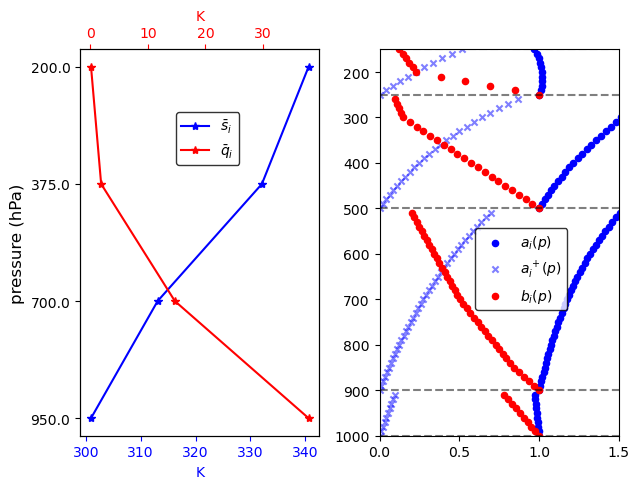

In [27]:
fig, axx = plt.subplots(1, 2, figsize = (6.5, 5))

ax = axx[0]
ln1, = ax.plot(sbar, range(obj[k].nlayers), c = 'blue', marker = '*')
ax2 = ax.twiny()
ln2, = ax2.plot(qbar, range(obj[k].nlayers), c = 'red', marker = '*')

ax.tick_params(color='blue', labelcolor='blue', axis = 'x')
ax2.tick_params(color='red', labelcolor='red', axis = 'x')
ax.set_xlabel('K', color = 'blue')
ax2.set_xlabel('K', color = 'red')


for a in [ax, ax2]:
    a.set_yticks(range(obj[k].nlayers))
    a.set_yticklabels( pmid )
    # for spine in ax.spines.values():
    #     spine.set_edgecolor('green')

# ax2.set_yticklabels( [] )
leg = ax.legend([ln1, ln2], ['$\\bar{s}_i$', '$\\bar{q}_i$'], loc = (0.4, 0.7))
leg.get_frame().set_edgecolor('k')
ax.set_ylabel('pressure (hPa)', size = 12)

ax = axx[1]
ax.scatter( alist, obj[k].profiles['pres'], c= 'blue', s =20, label = '$a_i(p)$')
ax.scatter( aplist, obj[k].profiles['pres'], c= 'blue', 
           marker = 'x', alpha=0.5, s =20, label = '$a^+_i(p)$')
ax.scatter( blist, obj[k].profiles['pres'], c= 'red', s =20, label = '$b_i(p)$')

ax.hlines(obj[k].pinterface, 0, 1.5, color = 'k', linestyle = '--', alpha = 0.5)
ax.set_xlim(0, 1.5)
ax.set_ylim(150, 1000)
leg = ax.legend( loc = (0.4, 0.325))
leg.get_frame().set_edgecolor('k')

ax.invert_yaxis()
plt.tight_layout()
SAVE = False
if SAVE:
    plt.savefig(f'/home/fiaz/STM/analysis/plots/Storyboard/vert_profiles_n={obj[k].nlayers}.pdf', dpi = 120, 
                bbox_inches = 'tight', format = 'pdf')